In [1]:
from lxml import etree
import numpy as np
import xml.etree.ElementTree as ET
import os
from scipy.ndimage import label
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

# GML MERGING FOR ALL BUILDINGS, INCLUDE TO FIXING THE LOWER AND UPPER CORNER INFORMATION

In [6]:
from lxml import etree
import os

def get_coordinates(corner_text):
    # Corner coordinates as float
    return list(map(float, corner_text.split()))

def update_corners(root, new_lower, new_upper):
    # Update Lower and Upper Corners
    for corner_tag in root.findall('.//{*}lowerCorner'):
        corner_text = f"{new_lower[0]} {new_lower[1]}"
        if len(new_lower) > 2:
            corner_text += f" {new_lower[2]}"
        corner_tag.text = corner_text

    for corner_tag in root.findall('.//{*}upperCorner'):
        corner_text = f"{new_upper[0]} {new_upper[1]}"
        if len(new_upper) > 2:
            corner_text += f" {new_upper[2]}"
        corner_tag.text = corner_text

def merge_citygml_files(file_list, output_file):
    first_file_loaded = False
    root = None
    min_lower = [float('inf')] * 3
    max_upper = [-float('inf')] * 3
    
    for file_name in file_list:
        tree = etree.parse(file_name)
        file_root = tree.getroot()
        
        # Gets coordinates of lower, upper
        lower_corner = get_coordinates(file_root.find('.//{*}lowerCorner').text)
        upper_corner = get_coordinates(file_root.find('.//{*}upperCorner').text)
        for i in range(len(lower_corner)):
            min_lower[i] = min(min_lower[i], lower_corner[i])
            max_upper[i] = max(max_upper[i], upper_corner[i])
        
        if not first_file_loaded:
            root = file_root
            first_file_loaded = True
        else:
            for element in file_root:
                root.append(element)
    
    # calls update_corners function
    update_corners(root, min_lower, max_upper)
    
    # Write the merged data as a new file
    tree = etree.ElementTree(root)
    tree.write(output_file, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Folder that contains all the gml files
folder_path = 'C:/Users/bb26k/Desktop/all_erfurts'
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.gml')]

# Output path
output_file = 'C:/Users/bb26k/Desktop/all_erfurt.gml'

# Calls merging function
merge_citygml_files(file_list, output_file)


FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: 'C:/Users/bb26k/Desktop/all_erfurts'

# GML IMPORTING AND EXTRACTING BOUNDARY UPPER, LOWER COORDINATES

In [7]:
tree = ET.parse('C:/Users/bb26k/Desktop/all_erfurt.gml')
root = tree.getroot()
    
ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/1.0'
}

# Boundary corner informations
lower = root.find(".//gml:lowerCorner", ns).text.split()
upper = root.find(".//gml:upperCorner", ns).text.split()

lower_x, lower_y, _ = map(float, lower)
upper_x, upper_y, _ = map(float, upper)
    
print("lowers", lower)
print("uppers", upper)

lowers ['638000.0', '5646000.0', '161.722']
uppers ['648000.0', '5654000.0', '364.579']


# CREATING VOXEL WITH DEFINED RESOLUTION
# IN NUMPY; THE COORDINATE SYSTEM IS (VERTICAL (Y), HORIZONTAL (X), Z). THEREFORE THE VOXEL PARAMETERS ARE (HEIGHT, WIDTH, Z)


In [8]:
voxel_space = np.zeros((8000, 10000, 70), dtype=np.uint8)

# IN GML FILE, THE FOOTPRIT COORDINATES OF A BUILDING STORED AS (X, Y, Z, ....X,Y,Z...,X,Y,Z) THEREFORE COORDINATES[0] MEANS X VALUE OF FIRST FOOTPRINT POINT COORDINATES. COORDINATES[1] MEANS Y VALUE OF FIRST FOOTPRINT POINT. 

# THOSE X AND Y COORDINATES ARE NORMALIZED INTO VOXEL COORDINATE SYSTEM. HOWEVER DURING THE Y COORDINATE NORMALIZATION DIFFERENT FORMULA USED BECAUSE IN GML FILE FOR EPSG25832 ORIGIN IS LOWER LEFT, WHILE IN NUMPY COORDINATE SYSTEM ORIGIN IS UPPER LEFT. THEREFORE IT IS REVERSED IN Y AXIS. WHILE ASSIGNING THOSE COORDINATES INTO VOXEL [Y, X, Z] USED DUE TO NUMPY NATURE.

# IN POSLIST, THE POLYGON CORNER POINTS OF THE BULDINGS STORED. EACH CORNER POINTS ARE CONSIDERED IN VOXELS BUT THE HEIGHT OF THE EACH POINT IS THE HEIGHT OF THE FIRST CORNER POINT OF THE BULDING. ALSO THE CORNER POINTS ARE EXTENDED TO 3X3 PATCHES FOR LARGER INTERSECTION AREAS. 

In [9]:
for building in root.findall(".//bldg:Building", ns):
    height_element = building.find('bldg:measuredHeight', ns)
    if height_element is None:
        continue
        
    height = float(height_element.text)
    voxel_height = int(height) # Yükseklik skalası

    footprint = building.find(".//gml:posList", ns)
    if footprint is None:
            continue

    # all corner positions taken into account
    coordinates = list(map(float, footprint.text.split()))
    num_points = len(coordinates) // 3  # Üçlü gruplar halinde düşün (x, y, z)

    for i in range(num_points):
        x = coordinates[3*i] 
        y = coordinates[3*i + 1]
            
        voxel_x = round((x - lower_x) / (upper_x - lower_x) * 9999)
        raw_voxel_y = round((upper_y - y) / (upper_y - lower_y) * 7999)
            
        # Check that no any other positions located at the outside of the boundary
        voxel_x = max(0, min(voxel_x, 9999))
        voxel_y = max(0, min(raw_voxel_y, 7999))
        voxel_height = min(voxel_height, 69)

        # Creates 3x3 patches with range of (-1,2)
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                new_voxel_x = voxel_x + dx
                new_voxel_y = voxel_y + dy
                if 0 <= new_voxel_x < 10000 and 0 <= new_voxel_y < 8000:
                    for z in range(voxel_height):
                        voxel_space[new_voxel_y, new_voxel_x, z] = 1

np.save("all_erfurt_1m_resolution.npy", voxel_space)

# LOADS CREATED VOXEL AND 2D RASTER IMAGE OF FOOTPRINTS

In [10]:
image = Image.open('C:/Users/bb26k/Desktop/source_1meter_perfectfit.tif').convert("L")
print("image size", image.size)

image_arr = np.array(image)
print("image array size", image_arr.shape)

voxel = np.load('C:/Users/bb26k/Desktop/all_erfurt_1m_resolution.npy')
print("voxel size", voxel.shape)

image size (10000, 8000)
image array size (8000, 10000)
voxel size (8000, 10000, 70)


# VISUALIZATION OF THE FIRST LAYER (Z=1) OF CREATED VOXEL DATA VS 2D BUILDING FOOTPRINT RASTER DATA


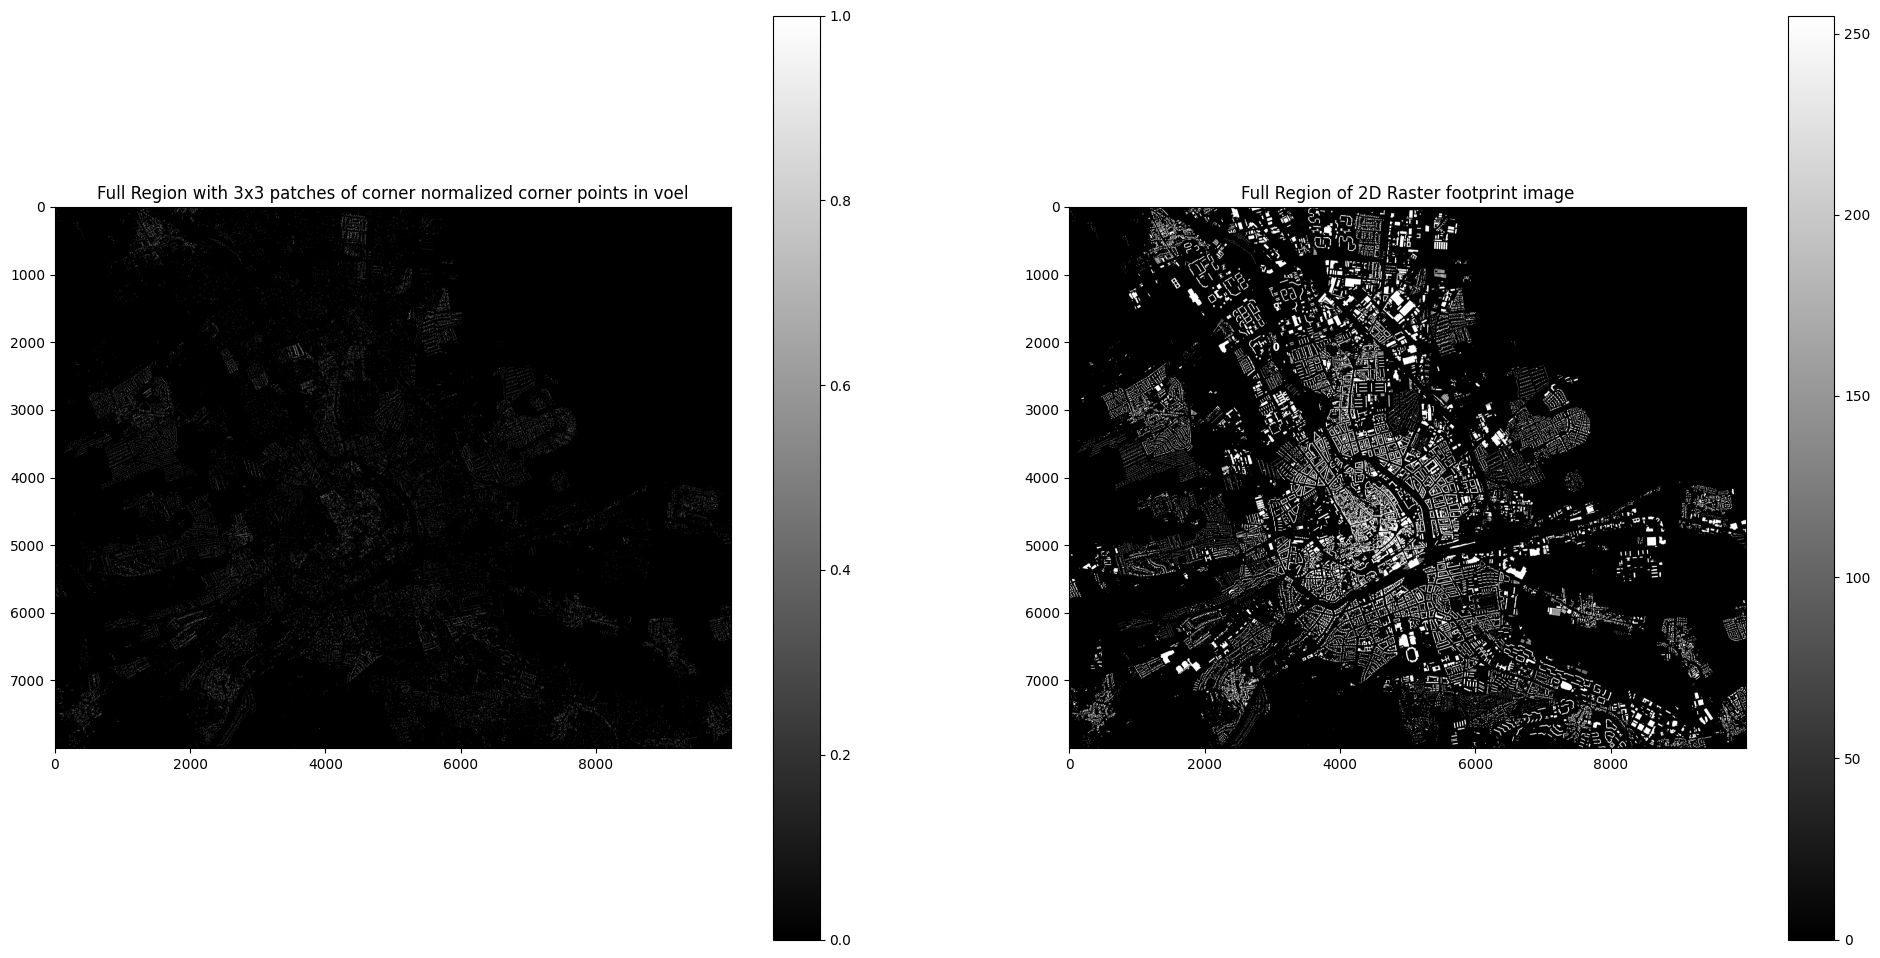

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Only visualize first z=1 layer
layer = voxel[:, :, 0]

fig, axs = plt.subplots(1, 2, figsize=(24, 12))  # 1 satır, 2 sütun

# Voxel z=0 visualization
im1 = axs[0].imshow(layer, cmap='gray')
axs[0].set_title('Full Region with 3x3 patches of corner normalized corner points in voel')
fig.colorbar(im1, ax=axs[0])

# Second visualization for loaded raster footprint image (image_arr)
im2 = axs[1].imshow(image_arr, cmap='gray')
axs[1].set_title('Full Region of 2D Raster footprint image')
fig.colorbar(im2, ax=axs[1])

plt.show()


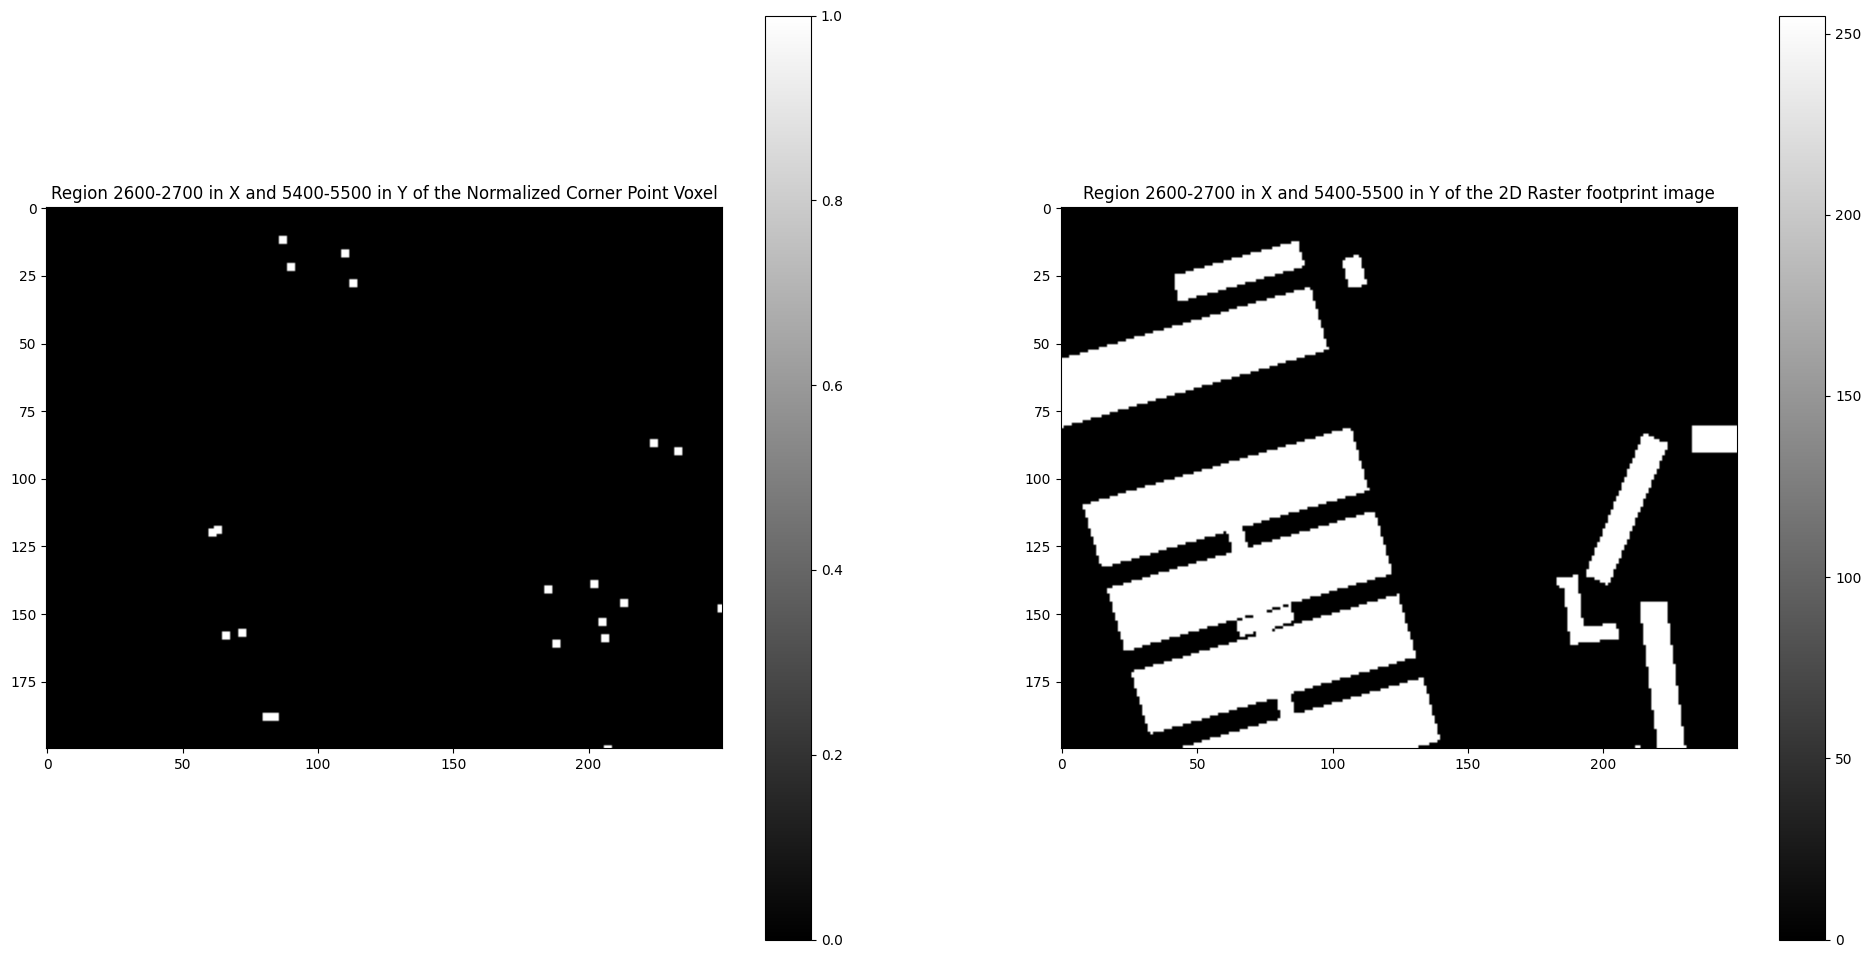

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Örnek bir voxel verisi oluşturuyorum

# İlk görselleştirme
layer = voxel[:, :, 0]

# Focus on more specific regions in the visualization
#x_start, x_end = 2600, 2700
#y_start, y_end = 5400, 5500

x_start, x_end = 2750, 3000
y_start, y_end = 4250, 4450
region_of_interest_1 = layer[y_start:y_end, x_start:x_end]
# Focus on more specific regions in the visualization
region_of_interest_2 = image_arr[y_start:y_end, x_start:x_end]

# Yan yana görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(24, 12))  # 1 satır, 2 sütun

im1 = axs[0].imshow(region_of_interest_1, cmap='gray')
axs[0].set_title('Region 2600-2700 in X and 5400-5500 in Y of the Normalized Corner Point Voxel')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(region_of_interest_2, cmap='gray')
axs[1].set_title('Region 2600-2700 in X and 5400-5500 in Y of the 2D Raster footprint image')
fig.colorbar(im2, ax=axs[1])

plt.show()



# Total number of closed features (buildings given below here)

In [16]:
labeled_image, num_features = label(image_arr > 0.5)
print("total number of buildings", num_features)

total number of buildings 26643


# CHECK THE INTERSECTION OF BULDING FOOTPRINTS WITH ANY OF THE CORNER POINTS FROM VOXEL. IF ONE OR MORE PIXEL IS MATCHED WITH THE FOOTPRINT, CREATES ANOTHER VOXEL WITH THE HEIGHT OF OF HIGHEST CORNER POINT AND FOOTPRINT OF THE VOXEL 

In [23]:
import numpy as np
from PIL import Image
from scipy.ndimage import label
import time

def assign_height_to_footprint(voxel, image_path):
    start_time = time.time()
    counter = 0
    
    image = Image.open(image_path).convert("L")
    image_arr = np.array(image)
    
    # A new voxel for created result
    result_voxel = np.zeros_like(voxel)

    # Label the buildings
    labeled_image, num_features = label(image_arr > 0.5)
    
    # Find the maximum height values for each label
    max_heights = np.zeros((num_features + 1,), dtype=int)
    indices = np.nonzero(voxel[:, :, 0])
    labels = labeled_image[indices]
    heights = np.sum(voxel[indices[0], indices[1], :], axis=1)
    
    np.maximum.at(max_heights, labels, heights)

    # Assign the height values to buildings
    for label_val in range(1, num_features + 1):
        height = max_heights[label_val]
        if height > 0:
            mask = (labeled_image == label_val)
            result_voxel[mask, :height] = 1
            counter = counter + 1
            if counter % 100 == 0:
                print(counter)
                
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Total number of identified footprints: {num_features}")
    print(f"Number of footprints matched with height values: {np.count_nonzero(max_heights > 0)}")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return result_voxel

# File Paths
voxel_path = 'C:/Users/bb26k/Desktop/all_erfurt_1m_resolution.npy'
image_path = 'C:/Users/bb26k/Desktop/source_1meter_perfectfit.tif'

# Load voxel
voxel = np.load(voxel_path)

# Call the function
result_voxel = assign_height_to_footprint(voxel, image_path)

# Save the result
np.save('result_voxel_patches3x3.npy', result_voxel)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

# VISUALIZATION OF THE LATEST CREATED VOXEL

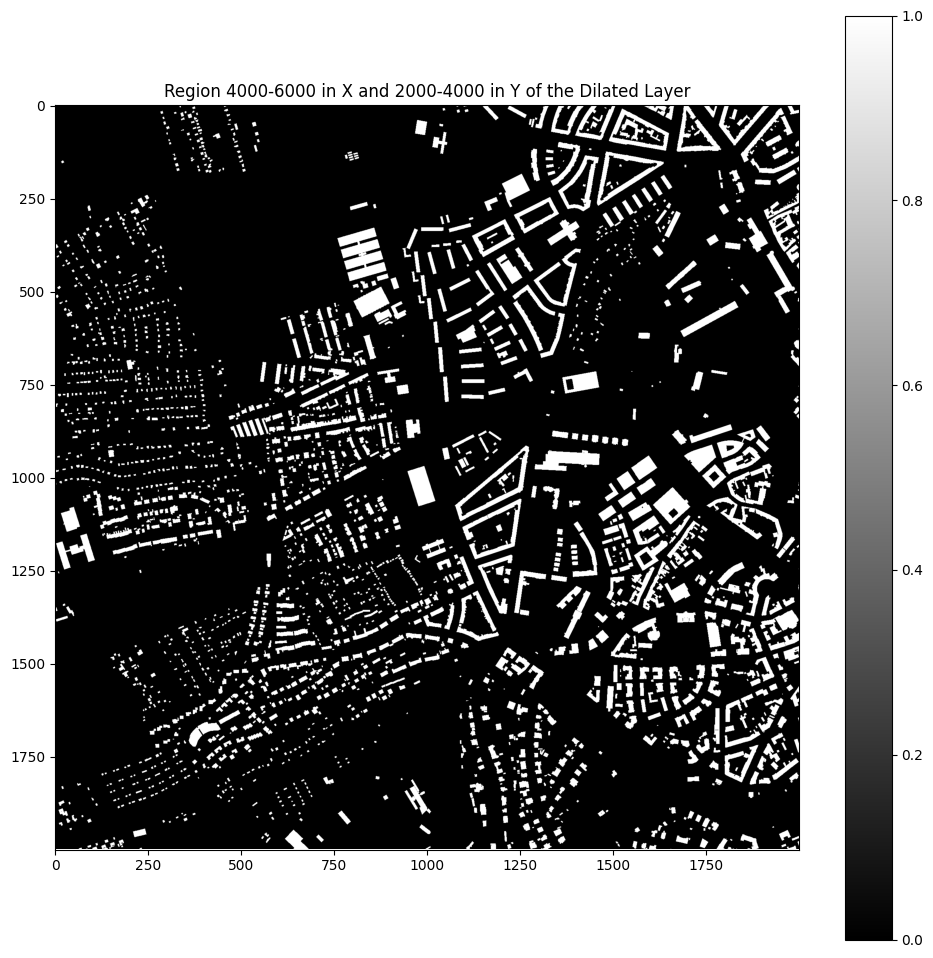

In [5]:
# Load the voxel data
voxel = np.load('result_voxel_patches3x3.npy')

# Select a specific layer (z=0)
layer = voxel[:, :, 0]

# Specify the region of interest
x_start, x_end = 2000, 4000
y_start, y_end = 4000, 6000
region_of_interest = layer[y_start:y_end, x_start:x_end]

# Visualize the specified region
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(region_of_interest, cmap='gray')
plt.title('Region 4000-6000 in X and 2000-4000 in Y of the Dilated Layer')
plt.colorbar()  # Add color bar
plt.show()


# THE ORGINAL 2D RASTER FOOTPRINT IMAGE OF THE SAME REGION FOR COMPARISON

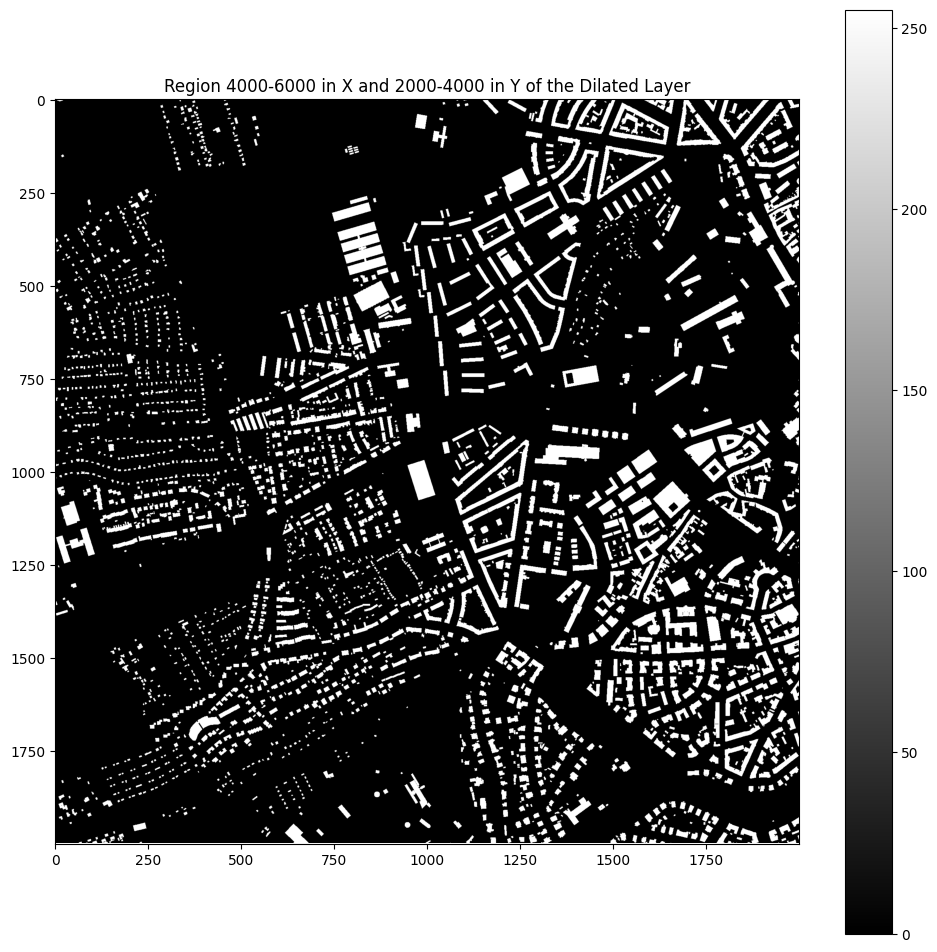

In [25]:

x_start, x_end = 2000, 4000
y_start, y_end = 4000, 6000
region_of_interest = image_arr[y_start:y_end, x_start:x_end]

# Visualize the specified region
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(region_of_interest, cmap='gray')
plt.title('Region 4000-6000 in X and 2000-4000 in Y of the Dilated Layer')
plt.colorbar()  # Add color bar
plt.show()

# COMPARISON WITH OTHER METHODOLOGIES SUCH AS USING POLYGON CREATION (THE POLYGON CREATION ALGORITHM EXECUTION TIME HIGHLY INFLUENCED BY THE SIZE OF THE VOXEL AND STILL THE RESULTS INFERIOR)

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def parse_gml_to_voxel_2(filename):
    # XML dosyasını oku
    tree = ET.parse(filename)
    root = tree.getroot()
    
    ns = {
        'gml': 'http://www.opengis.net/gml',
        'bldg': 'http://www.opengis.net/citygml/building/1.0'
    }
    counter = 0
    # Alanın sınırlarını al
    lower = root.find(".//gml:lowerCorner", ns).text.split()
    upper = root.find(".//gml:upperCorner", ns).text.split()

    lower_x, lower_y, _ = map(float, lower)
    upper_x, upper_y, _ = map(float, upper)

    # Voxel alanını oluştur
    voxel_space = np.zeros((2000, 2000, 70), dtype=np.uint8)
    
    total_buildings = len(root.findall(".//bldg:Building", ns))
    print(f"Total number of buildings: {total_buildings}")
    
    # Binalar için döngü
    for building in root.findall(".//bldg:Building", ns):
        height_element = building.find('bldg:measuredHeight', ns)
        if height_element is None:
            continue
        
        height = float(height_element.text)
        voxel_height = min(int(height), 69)  # Yükseklik skalası

        # Bina izlerini bul
        for footprint in building.findall(".//gml:posList", ns):
            coordinates = list(map(float, footprint.text.split()))
            # Polygon oluştur
            points = np.array([(coordinates[i], coordinates[i+1]) for i in range(0, len(coordinates), 3)])
            polygon_path = mpath.Path(points)
            grid = np.meshgrid(np.linspace(lower_x, upper_x, 2000), np.linspace(lower_y, upper_y, 2000))
            x_grid, y_grid = grid[0], grid[1]
            points_grid = np.vstack((x_grid.flatten(), y_grid.flatten())).T
            mask = polygon_path.contains_points(points_grid).reshape(2000, 2000)

            voxel_space[:, :, :voxel_height][mask] = 1
            counter = counter + 1
            if counter % 100 == 0:
                print("counter is", counter)
    # Sonucu kaydet
    np.save("640_5648_erfurt_1m_3.npy", voxel_space)

# Fonksiyonu çağır
parse_gml_to_voxel_2('C:/Users/bb26k/Desktop/all_erfurts/LoD2_32_640_5648_2_TH.gml')


z=0 layer initially has a total of 378600 white pixels
The dilated layer has a total of 378600 white pixels after dilation


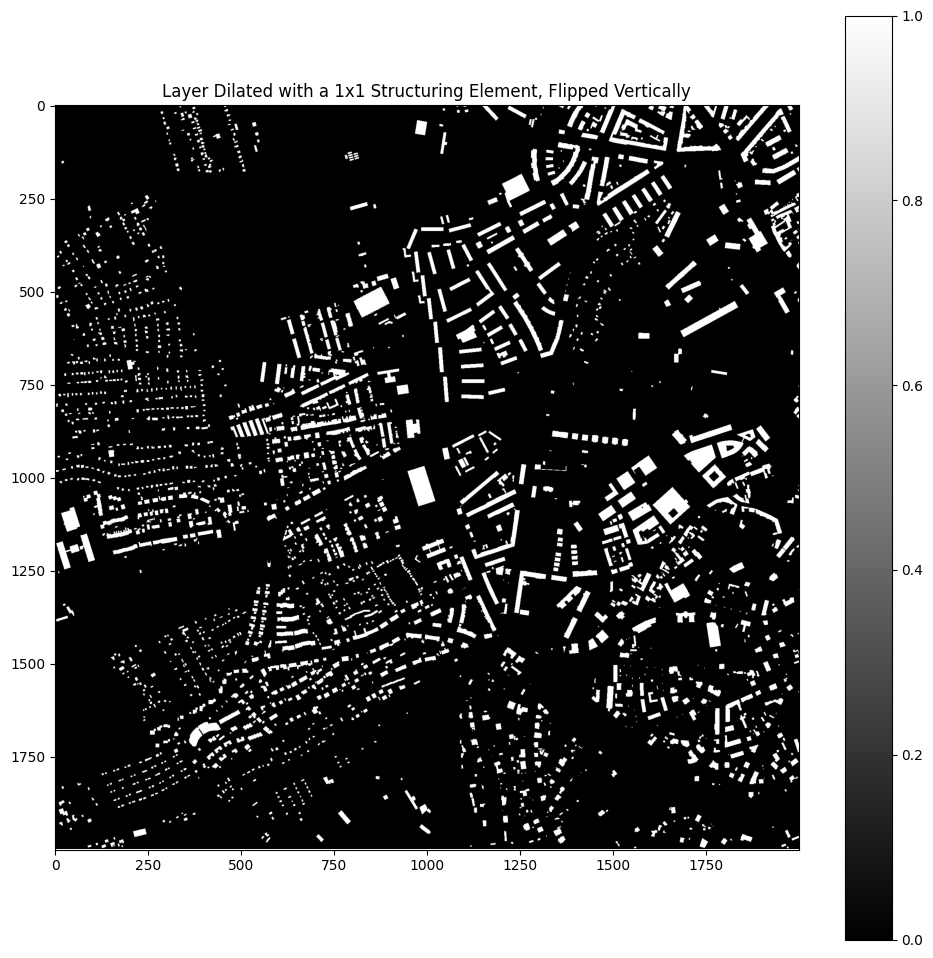

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Load the voxel data
voxel = np.load('C:/Users/bb26k/Desktop/640_5648_erfurt_1m_3.npy')

# Select a specific layer (z=0)
layer = voxel[:, :, 0]
initial_white_pixel_count = np.sum(layer)
print(f"z=0 layer initially has a total of {initial_white_pixel_count} white pixels")

# Create a structuring element for binary dilation
structure = np.ones((1, 1), dtype=np.uint8)  # Using a 1x1 structuring element for minimal dilation

# Apply binary dilation
dilated_layer = binary_dilation(layer, structure=structure)

# Calculate the number of white pixels in the dilated layer
white_pixel_count = np.sum(dilated_layer)
print(f"The dilated layer has a total of {white_pixel_count} white pixels after dilation")

# Visualize the dilated layer with vertical flip along the y-axis
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(dilated_layer[::-1, :], cmap='gray')  # Flipping the y-axis here
plt.title('Layer Dilated with a 1x1 Structuring Element, Flipped Vertically')
plt.colorbar()  # Add color bar
plt.show()


# CROPPING A SMALL REGION, THEN NPY TO VTK CONVERSION FOR PARAVIEW VISUALIZATION (During the conversion it is flipped in x-axis to make it consistent with .vtk format coordinate system)

In [12]:
import numpy as np

# Voxel dosyasını yükle
voxel_path = 'C:/Users/bb26k/Desktop/result_voxel_patches3x3.npy'
voxel = np.load(voxel_path)

# Kırpma aralığını belirle
x_start, x_end = 2200, 3800
y_start, y_end = 4000, 5000
z_end = 10

# Voxel verisini kırp
cropped_voxel = voxel[y_start:y_end, x_start:x_end, :z_end]

# Kırpılmış voxel verisini kaydet
output_path = 'cropped_voxel.npy'
np.save(output_path, cropped_voxel)

print(f"Cropped {output_path} is saved.")

Cropped cropped_voxel.npy is saved.


In [15]:
##DON'T IMPLMENET TRANSFORMATIONS
import vtk
from vtk.util import numpy_support
def save_as_vtk(data, filename):

    # Create VTK StructuredGrid object
    structuredGrid = vtk.vtkStructuredGrid()
    structuredGrid.SetDimensions(data.shape)

    # Create points for the structured grid
    points = vtk.vtkPoints()
    z_dim, y_dim, x_dim = data.shape
    print(z_dim, y_dim, x_dim)
    for z in range(z_dim):
        for y in range(y_dim):
            for x in range(x_dim):
                points.InsertNextPoint(x, y, z)
    structuredGrid.SetPoints(points)

    # Convert numpy array to VTK array
    vtk_data = numpy_support.numpy_to_vtk(num_array=data.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    structuredGrid.GetPointData().SetScalars(vtk_data)

    # Write data to .vtk file
    writer = vtk.vtkStructuredGridWriter()
    writer.SetFileName(filename)
    if vtk.VTK_MAJOR_VERSION <= 5:
        writer.SetInputConnection(structuredGrid.GetProducerPort())
    else:
        writer.SetInputData(structuredGrid)
    writer.Write()

    
voxel_path = 'C:/Users/bb26k/Desktop/cropped_voxel.npy'  
voxel = np.load(voxel_path)
flipped_voxel = np.flip(voxel, axis=0) #Flipped x due to vtk coordinate system
# Save the result as vtk file
save_as_vtk(flipped_voxel, "Gml_to_voxel_visualization.vtk")

1000 1600 10


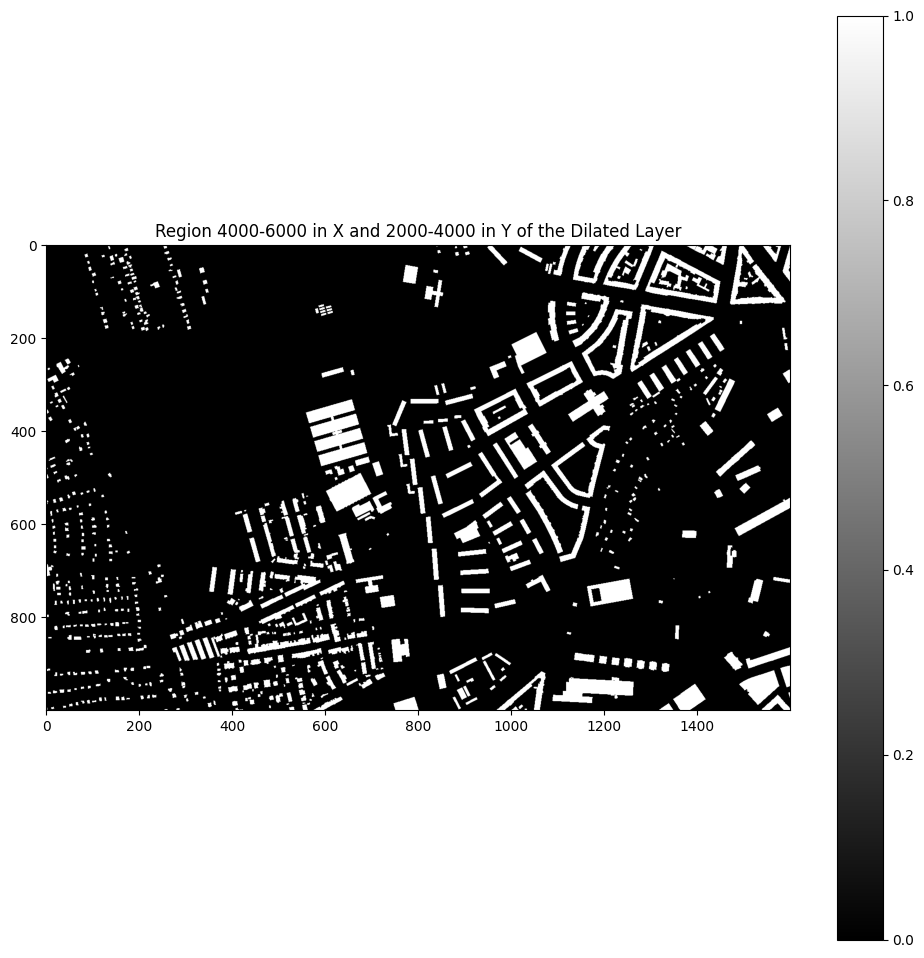

In [14]:
# Load the voxel data
voxel = np.load('cropped_voxel.npy')

# Select a specific layer (z=0)
layer = voxel[:, :, 0]



# Visualize the specified region
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(layer, cmap='gray')
plt.title('Region 4000-6000 in X and 2000-4000 in Y of the Dilated Layer')
plt.colorbar()  # Add color bar
plt.show()


# MAPING VOXEL TO 2D LOW RESOLUTION BULDING VOLUME DATA

[[   4088 1242927 1123081 1213250 1319015  862156       0       0       0
        0]
 [  79264  532965 1681076 2330865 3226330 1034364     508       0       0
        0]
 [ 215847  579171  819972 1815085 2768082  716402  109193  242630       0
        0]
 [ 151163  696441 1417139 2847158 4005261 2307063 1387393  605933       0
        0]
 [   7673  123304  587537 2500571 6742121 4116000  509860  513883  456177
   709122]
 [ 334182  269590  726992 2671375 4464347 3045344 1456641  331529  393337
    10760]
 [  80008  912209  934330  831838 2166715 2617549 1503949  619544  271902
   536159]
 [ 361277   32546  666386    1727   56444  548978  969602 1955058 1506882
   690215]]


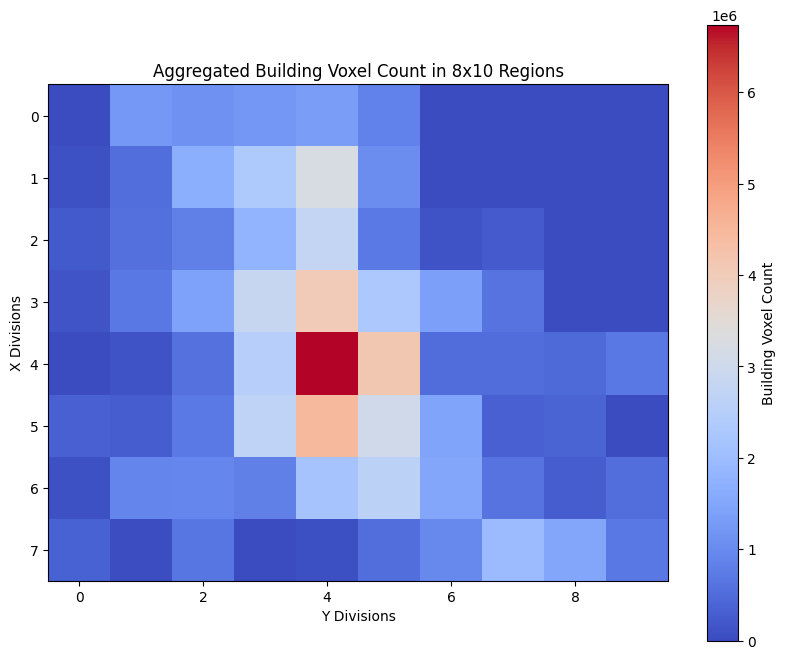

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def aggregate_building_voxels(voxel, x_div, y_div):
    # Get dimensions of the input voxel array
    x_size, y_size, z_size = voxel.shape
    
    # Determine the size of each region
    x_step = x_size // x_div
    y_step = y_size // y_div
    
    # Initialize the result array
    aggregated_voxel = np.zeros((x_div, y_div), dtype=int)
    
    # Aggregate building voxel counts in each region
    for i in range(x_div):
        for j in range(y_div):
            x_start = i * x_step
            x_end = (i + 1) * x_step
            y_start = j * y_step
            y_end = (j + 1) * y_step
            
            region = voxel[x_start:x_end, y_start:y_end, :]
            aggregated_voxel[i, j] = np.sum(region == 1)
    
    return aggregated_voxel
    

# Voxel dosyasını yükle
voxel_path = 'C:/Users/bb26k/Desktop/result_voxel_patches3x3_erfurt.npy'
voxel = np.load(voxel_path)

# 8x10'luk bölgelere ayır ve her bölgedeki toplam building voxel sayısını hesapla
x_div, y_div = 8, 10
aggregated_voxel = aggregate_building_voxels(voxel, x_div, y_div)
print(aggregated_voxel)
np.save('erfurt_building_volume.npy', aggregated_voxel)

# Sonuçları coolwarm renk skalasında görselleştir
plt.figure(figsize=(10, 8))
plt.imshow(aggregated_voxel, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Building Voxel Count')
plt.title('Aggregated Building Voxel Count in 8x10 Regions')
plt.xlabel('Y Divisions')
plt.ylabel('X Divisions')
plt.show()


# AIR TEMPERATURE DATA IS FILLEPED DUE TO COORDINATE SYSTEM

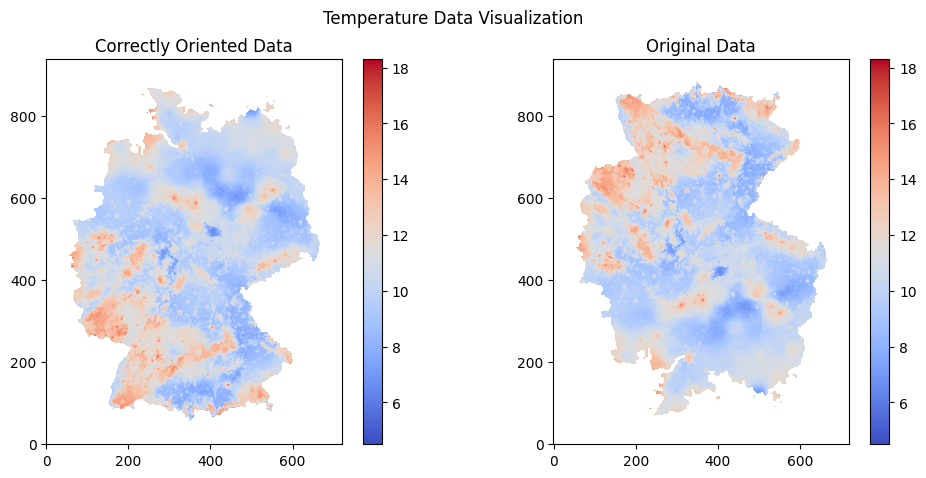

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Dosya yolunu belirle
file_name = 'C:/Users/bb26k/Desktop/tas_1hr_HOSTRADA-v1-0_BE_gn_2023070100-2023073123.nc'

# Veriyi yükle
data = xr.open_dataset(file_name)
data.load()

# 1. Görselleştirme için veri
temperature1 = data["tas"].sel(time=np.datetime64('2023-07-07T04:00:00'))

# 2. Görselleştirme için veri (flip edilmis)
temperature2 = np.flipud(temperature1)

# İki görselleştirmeyi yan yana plot et
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 1. Görselleştirme
axs[0].imshow(temperature1, cmap='coolwarm', origin='lower')
axs[0].set_title('Correctly Oriented Data')
axs[0].figure.colorbar(axs[0].images[0], ax=axs[0], orientation='vertical')

# 2. Görselleştirme
axs[1].imshow(temperature2, cmap='coolwarm', origin='lower')
axs[1].set_title('Original Data')
axs[1].figure.colorbar(axs[1].images[0], ax=axs[1], orientation='vertical')

# Başlıklar ve görselleştirme ayarları
plt.suptitle('Temperature Data Visualization')
plt.show()


# COORDINATE CONVERTER

In [5]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")

# Not exactly the boundary. If exact boundary is used, it becomes 7x10
x, y = 638000, 5646000
x2, y2 = 648000, 5654000

# Dönüşüm işlemi
lat, lon = transformer.transform(x, y)
lat2, lon2 = transformer.transform(x2, y2)

print(f"lat_min: {lat}, lon_min: {lon}")
print(f"lat_max: {lat2}, lon_max: {lon2}")

lat_min: 50.949079298521255, lon_min: 10.96459317696989
lat_max: 51.018490071578604, lon_max: 11.110113349570112


# Better boundary selection (maximum latitude increased to 51.025)

Differences between min-max lat-lon from the data and actual boundary lat lon  (lat, lon):
Min Lat difference: -0.008020616029526195, Max Lat difference: -0.004909281448739478
Min Lon difference: -0.0009067009597973907, Max Lon difference: 0.010513511313275714


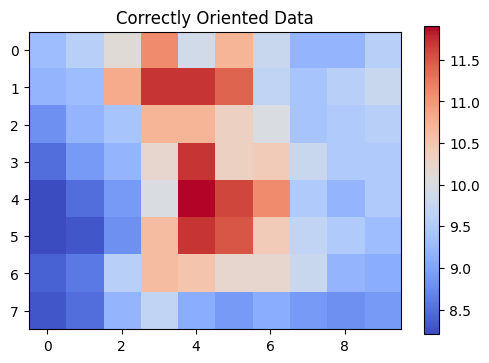

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Dosya yolunu belirle
file_name = 'C:/Users/bb26k/Desktop/tas_1hr_HOSTRADA-v1-0_BE_gn_2020070100-2020073123.nc'

# Veriyi yükle
data = xr.open_dataset(file_name)
data.load()

# Koordinat aralıklarını belirle
lat_baslangic, lat_bitis = 50.949079298521255, 51.025 #approximetly 600-700 meter shifted above
lon_baslangic, lon_bitis = 10.96459317696989, 11.110194965946947

# Maskeleri oluştur
lat_mask = (data["lat"] >= lat_baslangic) & (data["lat"] <= lat_bitis)
lon_mask = (data["lon"] >= lon_baslangic) & (data["lon"] <= lon_bitis)
combined_mask = lat_mask & lon_mask

# Sıcaklık verisini kırp
temperature_crop = data["tas"].where(combined_mask, drop=True)

# Kırpma işlemi sonucunun boş olup olmadığını kontrol et
if temperature_crop.size == 0:
    raise ValueError("The cropped data array is empty. Please check your masking conditions.")

# Belirli bir zaman diliminde sıcaklık verisini seç ve flip et
temperature_time1 = temperature_crop.sel(time=np.datetime64('2020-07-07T01:00:00'))
temperature_time1_flipped = np.flipud(temperature_time1)

# Koordinatları al
latitudes = temperature_crop["lat"].values
longitudes = temperature_crop["lon"].values

# Minimum ve maksimum lat/lon değerlerini belirle
min_lat, max_lat = np.min(latitudes), np.max(latitudes)
min_lon, max_lon = np.min(longitudes), np.max(longitudes)

# Minimum ve maksimum lat/lon değerlerini yazdır
print("Differences between min-max lat-lon from the data and actual boundary lat lon  (lat, lon):")
print(f"Min Lat difference: {lat - min_lat}, Max Lat difference: {lat2- max_lat}")
print(f"Min Lon difference: {lon - min_lon}, Max Lon difference: {lon2 - max_lon}")

# Görselleştirme
plt.figure(figsize=(6, 4))
plt.imshow(temperature_time1_flipped, cmap='coolwarm')
plt.colorbar()
plt.title('Correctly Oriented Data')
plt.show()

# 2020, July Erfurt Average Mean Temperature at 01:00 AM

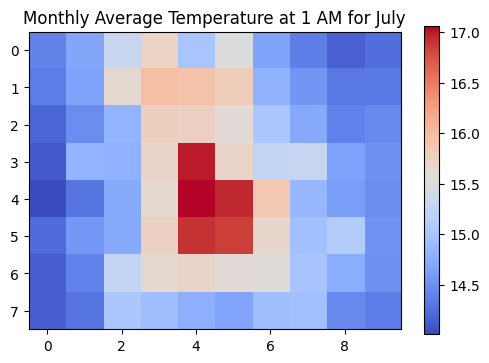

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Dosya yolunu belirle
file_name = 'C:/Users/bb26k/Desktop/tas_1hr_HOSTRADA-v1-0_BE_gn_2020070100-2020073123.nc'

# Veriyi yükle
data = xr.open_dataset(file_name)
data.load()

# Koordinat aralıklarını belirle
lat_baslangic, lat_bitis = 50.949079298521255, 51.025 #approximetly 600-700 meter shifted above
lon_baslangic, lon_bitis = 10.96459317696989, 11.110194965946947

# Maskeleri oluştur
lat_mask = (data["lat"] >= lat_baslangic) & (data["lat"] <= lat_bitis)
lon_mask = (data["lon"] >= lon_baslangic) & (data["lon"] <= lon_bitis)
combined_mask = lat_mask & lon_mask

# Sıcaklık verisini kırp
temperature_crop = data["tas"].where(combined_mask, drop=True)

# Gece 01:00'deki verileri seç
temperature_at_1AM = temperature_crop.sel(time=temperature_crop.time.dt.hour == 1)

# Aylık ortalama hesapla
monthly_average_temp = temperature_at_1AM.groupby("time.month").mean()

# Aylık ortalamadan bir örnek seç (örneğin Temmuz ayı)
example_monthly_average = monthly_average_temp.sel(month=7)

numpy_array = np.flipud(example_monthly_average.values)  # NumPy dizisine çevir
np.save('erfurt_july_temp.npy', numpy_array)  # Kaydet

# Görselleştirme
plt.figure(figsize=(6, 4))
plt.imshow(np.flipud(example_monthly_average.squeeze()), cmap='coolwarm')  # Veriyi y-ekseni boyunca flip et
plt.colorbar()
plt.title('Monthly Average Temperature at 1 AM for July')
plt.show()
